In [1]:
# run this cell
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#Run this
#!pip install albumentations > /dev/null
#!pip install -U efficientnet==0.0.4
!pip install keras_efficientnets
#%tensorflow_version 1.x
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply, Subtract, AveragePooling2D
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils, plot_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

#tf.set_random_seed(seed)
    
%matplotlib inline

In [4]:
# run this cell
import tensorflow
print(tensorflow.__version__)

2.2.0


In [5]:
def mse_block(x_input):  # this block takes a block of input shape (256, 256, nb_channels) )(256,256, 64)
  x_in1 = GlobalAveragePooling2D()(x_input)
  x_in1 = Dense(int(x_input.shape[-1]//4) , activation = 'relu')(x_in1)
  x_in1 = Dense(int(x_input.shape[-1]), activation = 'sigmoid')(x_in1)
  s1 = Multiply()([x_in1 , x_input])

  x_in2 = Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same')(x_input)
  x_in2 = Conv2DTranspose (filters = 1, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'sigmoid')(x_in2)
  s2 = Multiply()([x_in2 , x_input])
  

  x_in3 = GlobalAveragePooling2D()(x_input)
  x_in3 = Dense(int(x_input.shape[-1]*4) , activation = 'relu')(x_in3)
  x_in3 = Dense(int(x_input.shape[-1]), activation = 'sigmoid')(x_in3)
  s3 = Multiply()([x_in3 , x_input])

  x_in4 = Conv2DTranspose (filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same')(x_input)
  x_in4 = Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'sigmoid')(x_in4)
  s4 = Multiply()([x_in4 , x_input])

  #s1_0 =  Dense(int(x_input.shape[-1]), activation = jahin_activation)(x_in1)
  #s1_0 =  Multiply()([s1_0 , x_input])
  #s1_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (1,1), strides = (1,1), padding = 'same', activation= 'relu')(s1_0)
    
  s2_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (1,1), padding = 'same', activation= jahin_activation)(x_in2)
  s2_0 =  Multiply()([s2_0 , x_input])
  s2_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (1,1), strides = (1,1), padding = 'same', activation= 'relu')(s2_0)
  
  #s12_0 = Concatenate() ([s1_0, s2_0])
  #s12_0 = Conv2D (filters = int(x_input.shape[-1]), kernel_size = (1,1),strides = (1,1), padding = 'same' , activation = 'relu')(s12_0)
  out = Concatenate() ([s1, s3, s2, s4])
  out = Conv2D (filters = int(x_input.shape[-1]), kernel_size = (1,1),strides = (1,1), padding = 'same' , activation = 'relu')(out)
  out = Add()([out , x_input])
  #out = Subtract()([out, s2_0])
  
  return out

In [6]:
from keras_efficientnets import EfficientNetB5

backbone = EfficientNetB5(weights='imagenet',
                          include_top=False,
                          input_shape=(256, 256, 3))

backbone = Model(backbone.input, backbone.layers[515].output)
backbone.summary()

115302400/115295288 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
_________________________

In [8]:
def jahin_activation(x):
    return (1. / (1. + K.exp(5*(x-0.5))))

In [11]:
#To train/load ... to train, comment last line
def M_unet(backbone, heavier=0):
  a1 = backbone.layers[41].output   #128x128x144       |
  a2 = backbone.layers[115].output  #64x64x240         |
  a3 = backbone.layers[189].output  #32x32x384         |    <--encoder
  a4 = backbone.layers[397].output  #16x16x1056        |
  a5 = backbone.layers[-1].output   #8x8x1824          |


  
  def just_conv(x, filter_, ker=3, up=0):
      if up:  x= UpSampling2D((2,2))(x)
      x = Conv2D(filter_, (ker,ker), activation='relu', padding='same')(x)
      return x

  factor=1
  if heavier: factor=2

  a10 = just_conv(a1, 16*factor, up=1)
  a20 = just_conv(a2, 32*factor, up=1)
  a30 = just_conv(a3, 64*factor, up=1)
  a40 = just_conv(a4, 128*factor, up=1)
  a50 = just_conv(a5, 256*factor, up=1)


  a10 = mse_block((a10))
  a20 = mse_block((a20))
  a30 = mse_block((a30))
  a40 = mse_block((a40))
  a50 = mse_block((a50))
  
  b6 = just_conv(a5, 256*factor)                                    #           |            
  b6 = just_conv(b6, 256*factor, up=1)

  b5 = concatenate([b6,a50], axis=-1)                               #           |
  b5 = just_conv(b5, 256*factor)
  # b5 = just_conv(b5, 256*factor)
  b5 = Conv2D(256*factor, 3*3, activation='relu', padding='same', name = 'b5')(b5)

  b4 = concatenate([just_conv(b5, 256*factor, up=1), a40], axis=-1) #           |
  b4 = just_conv(b4, 128*factor)
  b4 = Conv2D(128*factor, 3*3, activation='relu', padding='same', name = 'b4')(b4)

  b3 = concatenate([just_conv(b4, 128*factor, up=1), a30], axis=-1) #           |  <--decoder
  b3 = just_conv(b3, 64*factor)
  b3 = Conv2D(64*factor, 3*3, activation='relu', padding='same', name = 'b3')(b3)

  b2 = concatenate([just_conv(b3, 64*factor, up=1), a20], axis=-1)  #           |
  b2 = just_conv(b2, 32*factor)
  b2 = Conv2D(32*factor, 3*3, activation='relu', padding='same', name = 'b2')(b2)

  b1 = concatenate([just_conv(b2, 32*factor, up=1), a10], axis=-1)  #           |
  b1 = just_conv(b1, 16*factor)
  b1 = Conv2D(16*factor, 3*3, activation='relu', padding='same', name = 'b1')(b1)                                  #           |

  
  b10 = mse_block((b1))
  b20 = mse_block((b2))
  b30 = mse_block((b3))
  b40 = mse_block((b4))
  b50 = mse_block((b5))


  b10 = Conv2D(16, (1,1), activation='relu', padding='same', name = 'b10')(b10)

  b20 = just_conv(b20, filter_=16, ker=1)
  b20 = UpSampling2D((2,2) , name = 'b20')(b20)

  b30 = just_conv(b30, filter_=16, ker=1)
  b30 = UpSampling2D((4,4), name = 'b30')(b30)

  b40 = just_conv(b40, filter_=16, ker=1)
  b40 = UpSampling2D((8,8), name = 'b40')(b40)

  b50 = just_conv(b50, filter_=16, ker=1)
  b50 = UpSampling2D((16,16), name = 'b50')(b50)

  b_all = concatenate([b10, b20, b30, b40, b50], axis=-1)
   
  out = Conv2D(1, (1, 1), activation='sigmoid')(b_all)

  model= Model(backbone.input, out)

  print(b5.shape)
  print(b4.shape)
  print(b3.shape)
  print(b2.shape)
  print(b1.shape)
  return model



m_unet= M_unet(backbone,0)
m_unet.summary()
#m_unet.compile(optimizer=Adam(lr=1.5e-3), loss='binary_crossentropy', metrics=[dice_coef])
m_unet.load_weights ('/content/drive/My Drive/CT_SCAN_SARS-COV_2/h5s/Copy of m_unet_jahin_custAct_rpp+_mse_80by20_5.h5')   #m_unet_light_lr1.5e_3_jahin_rpp.h5 == 90.36% 

(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 128, 128, 32)
(None, 256, 256, 16)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][

ValueError: ignored

In [ ]:


def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    
# encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#middle
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name = 'middle_point')(conv5)
# decoder
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'up7')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

unet = unet()
unet.load_weights("/content/drive/My Drive/CT_SCAN_SARS-COV_2/final_unet/mosmeddata_unet/63_percent.h5")

In [10]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [ ]:
# from efficientnet import EfficientNetB4

# def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

#     backbone = EfficientNetB4(weights='imagenet',
#                             include_top=False,
#                             input_shape=input_shape)
#     input = backbone.input
#     start_neurons = 8

#     conv4 = backbone.layers[342].output
#     conv4 = LeakyReLU(alpha=0.1)(conv4)
#     pool4 = MaxPooling2D((2, 2))(conv4)
#     pool4 = Dropout(dropout_rate)(pool4)
    
#      # Middle
#     convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
#     convm = residual_block(convm,start_neurons * 32)
#     convm = residual_block(convm,start_neurons * 32)
#     convm = LeakyReLU(alpha=0.1)(convm)
    
#     deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
#     deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
#     deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
#     deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
#     uconv4 = concatenate([deconv4, conv4])
#     uconv4 = Dropout(dropout_rate, name='conv_mid_right')(uconv4) 
    
#     uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
# #   uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
#     deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
#     deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
#     conv3 = backbone.layers[154].output
#     uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
#     uconv3 = Dropout(dropout_rate)(uconv3)
    
#     uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
# #     uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = LeakyReLU(alpha=0.1)(uconv3)

#     deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
#     conv2 = backbone.layers[92].output
#     uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
#     uconv2 = Dropout(0.1)(uconv2)
#     uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
# #     uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
#     deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     conv1 = backbone.layers[30].output
#     uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
#     uconv1 = Dropout(0.1)(uconv1)
#     uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
# #     uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
#     uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
#     uconv0 = Dropout(0.1)(uconv0)
#     uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
# #     uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
#     uconv0 = Dropout(dropout_rate/2)(uconv0)
#     output_layer = Conv2D(3, (1,1), padding="same", activation="softmax")(uconv0)    
    
#     model = Model(input, output_layer)
#     model.name = 'u-xception'

#     return model

In [ ]:
# K.clear_session()
# img_size = 256
# model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

In [ ]:
# model.summary()

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model)

In [ ]:
# u_net_weights = "/content/drive/My Drive/CT_SCAN_SARS-COV_2/final_unet/unet++efficientnet/full_coronacases_unet++efficientnet.h5"
# model.load_weights(u_net_weights)

In [ ]:
# run this
for layer in m_unet.layers:
	layer.trainable = False

In [ ]:
# # run this cell

# for layer in unet.layers:
#   layer.trainable = False

In [ ]:
# a = m_unet.layers[-2].output
# b = m_unet.layers[-10].output
# c = m_unet.layers[-26].output
# d = m_unet.layers[-54].output
# e = m_unet.layers[-84].output

a = m_unet.get_layer('b1').output
b = m_unet.get_layer('b2').output
c = m_unet.get_layer('b3').output
d = m_unet.get_layer('b4').output
e = m_unet.get_layer('b5').output

print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
print(e.shape)

a = Conv2D(16, kernel_size= 1 , strides = 2, padding = 'same')(a)
c = UpSampling2D (size = (2,2))(c)
d = UpSampling2D (size = (4,4))(d)
e = UpSampling2D (size = (8,8))(e)
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
print(e.shape)

(None, 256, 256, 16)
(None, 128, 128, 32)
(None, 64, 64, 64)
(None, 32, 32, 128)
(None, 16, 16, 256)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 128, 128, 64)
(None, 128, 128, 128)
(None, 128, 128, 256)


In [ ]:
temp_model = Model (inputs = m_unet.input, outputs = [e, d, c, b, a] )
temp_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
# run this cell
def m_attention_block(slice_x):
        basket=[]
        y = temp_model(slice_x)
        for i in range(0,5):
          #name = "up"+str(i)
          #out = unet.get_layer(name).output
          #temp_model = Model(inputs = unet.input, outputs = out)
          x = mse_block(y[i])          
          #x = Add()([x, x2])

          x = Conv2D(64, (1,1), activation= "relu", padding="same")(x)
          

          while x.shape[1]!= 256: x= UpSampling2D((2,2))(x)
          x = Conv2D(3, (3,3), activation= "sigmoid", padding="same")(x)
          x = Multiply()([slice_x, x])
          
          #x = model_vgg(x)
          #x = Conv2D(64, (1,1), activation= "relu", padding="same")(x)
          basket.append(x)
        x = Concatenate(axis=-1)(basket)

        
        return x


x0 = Input((256,256,3))
y0 = m_attention_block(x0)

m_attention = Model(x0,y0)

In [ ]:
#Run this
from keras.layers import Multiply


def approach_1_block(in_shape):
    x_in = Input(in_shape)
    slice_num= x_in.shape[-1]
    
    branch = []
    
    """
    def s_e_block(in_block):
        x = GlobalAveragePooling2D()(in_block)
        x = Dense(int(in_block.shape[-1]//2), activation='relu')(x)
        x = Dense(int(in_block.shape[-1]), activation='sigmoid')(x)
        return Multiply()([in_block, x])
    
    
    def attention_block(slice_x, name_val):
        basket=[]
        for i in range(5,10):
          name = "up"+str(i)
          out = unet.get_layer(name).output
          
          temp_model = Model(inputs = unet.input, outputs = out)
          x2 = temp_model(slice_x)
          
          
          
          x = s_e_block(x2)
          x = Add()([x, x2])
          
          
          
          x = Conv2D(64, (1,1), activation= "relu", padding="same")(x)          
          while x.shape[1]!= 256: x= UpSampling2D((2,2))(x)
          name_0= str(name_val) + '_up_layer_' + str(i)
          
          x = Conv2D(3, (3,3), activation= "sigmoid", padding="same", name= name_0)(x)
          x = Multiply()([slice_x, x])
      
          basket.append(x)
        x = Concatenate(axis=-1)(basket)
        
        return x
    """
   

    for i in range(slice_num):
        print(i)
        x_out = Lambda(lambda x: x[:,:,:,:,i])(x_in)  
        x_out_1= m_attention(x_out)
        
        ##modify
        x_out_1 = Conv2D(64, (3,3), activation= "relu", padding="same")(x_out_1)
        #x_out_1 = Conv2D(64, (3,3), activation= "relu", padding="same")(x_out_1)
        x_out_1 = MaxPooling2D((2,2))(x_out_1)
        x_out_1 = Conv2D(128, (3,3), activation= "relu", padding="same")(x_out_1)
        #x_out_1 = Conv2D(128, (3,3), activation= "relu", padding="same")(x_out_1)
        x_out_1 = MaxPooling2D((2,2))(x_out_1)
        x_out_1 = Conv2D(256, (3,3), activation= "relu", padding="same")(x_out_1)
        #x_out_1 = Conv2D(256, (3,3), activation= "relu", padding="same")(x_out_1)
        
        print(x_out_1.shape)
        ##
        x_out_1 = GlobalAveragePooling2D()(x_out_1)
        x_out_1 = LeakyReLU(alpha=0.1) (x_out_1)
        x_out_1 = Dropout(0.1)(x_out_1)
        x_out_1 = Dense(32, activation='relu')(x_out_1)
        
        branch.append(x_out_1)
    
    x = Concatenate(axis=-1)(branch)
    print(x.shape)

    #x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    print(x.shape)
    
    model = Model(x_in, x)

    return model


In [ ]:
#Run this
model_approach= approach_1_block((256, 256, 3, 30))

0
(None, 64, 64, 256)
1
(None, 64, 64, 256)
2
(None, 64, 64, 256)
3
(None, 64, 64, 256)
4
(None, 64, 64, 256)
5
(None, 64, 64, 256)
6
(None, 64, 64, 256)
7
(None, 64, 64, 256)
8
(None, 64, 64, 256)
9
(None, 64, 64, 256)
10
(None, 64, 64, 256)
11
(None, 64, 64, 256)
12
(None, 64, 64, 256)
13
(None, 64, 64, 256)
14
(None, 64, 64, 256)
15
(None, 64, 64, 256)
16
(None, 64, 64, 256)
17
(None, 64, 64, 256)
18
(None, 64, 64, 256)
19
(None, 64, 64, 256)
20
(None, 64, 64, 256)
21
(None, 64, 64, 256)
22
(None, 64, 64, 256)
23
(None, 64, 64, 256)
24
(None, 64, 64, 256)
25
(None, 64, 64, 256)
26
(None, 64, 64, 256)
27
(None, 64, 64, 256)
28
(None, 64, 64, 256)
29
(None, 64, 64, 256)
(None, 960)
(None, 1)


In [ ]:
# # run this cell
# out = unet.get_layer("up7").output
# model_cut_right = Model(inputs = unet.input, outputs = out)
# model_cut_right.summary()

In [ ]:
# out = model.get_layer("conv_middle").output
# model_cut_en = Model(inputs = model.input, outputs = out)
# #model_cut_en.summary()

# out = model.get_layer("conv_mid_right").output
# model_cut_right = Model(inputs = model.input, outputs = out)
# model_cut_right.summary()

In [ ]:
# # run this cell
# from keras.layers import *
# def volume_feature_map(in_shape):
#     x_in_0 = Input(in_shape)
#     slice_num= x_in_0.shape[-1]
#     print(x_in_0.shape)
#     x_in = Reshape((256, 256, 3, slice_num))(x_in_0)
#     branch = []
#     for i in range(slice_num):
#         x_out = Lambda(lambda x: x[:,:,:,:,i])(x_in)
#         x_out = model_cut_right(x_out)
#         #print(x_out.shape)
#         x_out = Conv2D(16, (3, 3), activation='relu', padding='same')(x_out)
#         #print(x_out.shape)
#         branch.append(x_out)
#         print(i)
        
    
#     x = Concatenate(axis=-1)(branch)
    
    
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = GlobalAveragePooling2D()(x)
#     # x = Flatten()(x)

#     x = LeakyReLU(alpha=0.1) (x)
#     x = Dropout(0.1)(x)
#     print(x.shape)
#     x = Dense(128, activation='relu')(x)
#     x= Dense(64, activation = 'relu')(x)
#     x = Dense(1, activation='sigmoid')(x)
    
#     model = Model(x_in_0, x)
    
    
#     return model

In [ ]:
# # run this cell
# model_appended=volume_feature_map((256, 256, 3, 29)) #change 10 to 35 or 40

In [ ]:
# run this cell
model_approach.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3,  0                                            
__________________________________________________________________________________________________
lambda_40 (Lambda)              (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_41 (Lambda)              (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_42 (Lambda)              (None, 256, 256, 3)  0           input_3[0][0]                    
___________________________________________________________________________________________

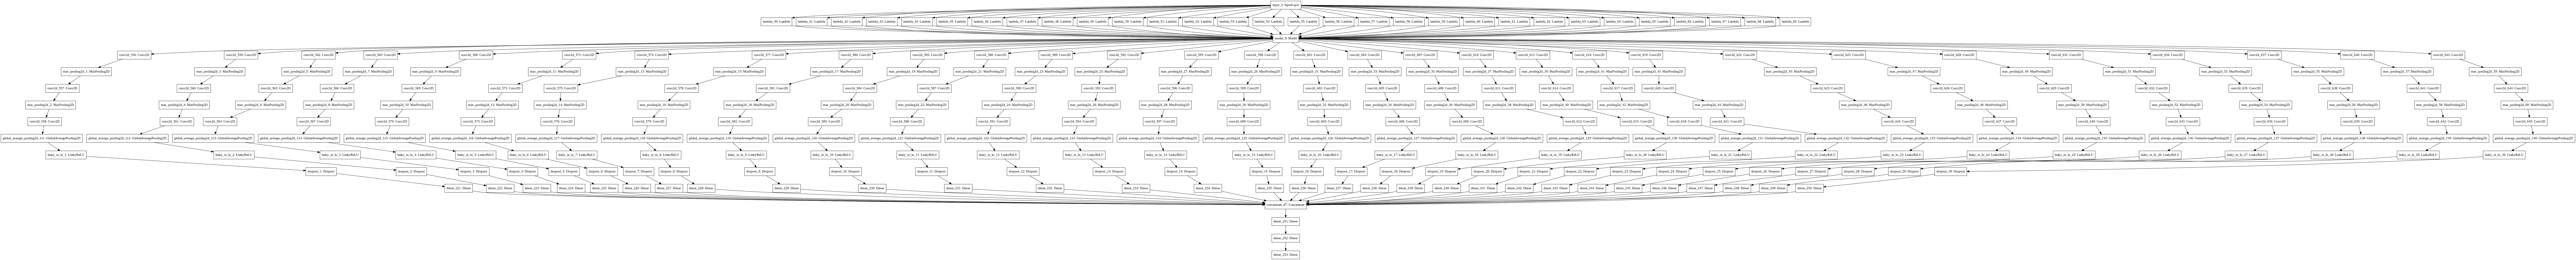

In [ ]:
# run this cell
from keras.utils.vis_utils import plot_model
plot_model(model_approach)

In [ ]:
# # run this cell
# im_dir = "/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/CLASSIFIER_PATIENT_WISE/train"
# a1 = os.path.join(im_dir, os.listdir(im_dir)[0])
# a2 = os.path.join(im_dir, os.listdir(im_dir)[1])
# bunches = 270
# patients = len(os.listdir(a1))+len(os.listdir(a2))



In [ ]:
# # run this cell
# init = 0  #don't exceed 5
# bunch_1= bunches/2
# bunch_0= bunches/2

# if (len(os.listdir(a1))-bunch_1*(init+1)) <10: 
#   rest1 = int(len(os.listdir(a1))-bunch_1*(init+1))
# else :
#   rest1 = 0

# if (len(os.listdir(a2))-bunch_0*(init+1)) <10: 
#   rest2 = int(len(os.listdir(a2))-bunch_0*(init+1))
# else :
#   rest2 = 0

# X = np.empty((bunches+rest1+rest2, 256, 256, 3, 29), dtype= np.float64)
# Y = np.empty((bunches+rest1+rest2), dtype= int)

# X.shape

(270, 256, 256, 3, 29)

In [ ]:
# # run this cell
# import cv2
# for j in range(int(bunch_1*init), int(bunch_1*(init+1)+rest1)):
#     a1_1= os.path.join(a1, os.listdir(a1)[j])  #patients
#     a1_1_1= np.sort(random.sample(os.listdir(a1_1), 29))  #29 sampling
#     for m in range(len(a1_1_1)):
#         a111_im = os.path.join(a1_1, a1_1_1[m])
#         a111_im = cv2.imread(a111_im)
#         a111_im = resize(a111_im, (256, 256,3), anti_aliasing=True)
#         X[j, :,:,: ,m] = a111_im
#         print("patient : " + str(j) + " slice : " +str(m))
#         Y[j] = 1

In [ ]:
# # run this cell
# for j in range(int(bunch_1*(init+1)+rest1)+int(bunch_0*init),int(bunch_1*(init+1)+rest1)+int(bunch_0*(init+1)+rest2)):
#     a2_1= os.path.join(a2, os.listdir(a2)[j - int(bunch_0)])  #patients
#     a2_1_1= np.sort(random.sample(os.listdir(a2_1), 29))  #29 sampling
#     for m in range(len(a2_1_1)):
#         a211_im = os.path.join(a2_1, a2_1_1[m])
#         a211_im = cv2.imread(a211_im)
#         a211_im = resize(a211_im, (256, 256, 3), anti_aliasing=True)
#         X[j, :,:,:,m ] = a211_im
#         print("patient : " + str(j) + " slice : " +str(m))
#         Y[j] = 0

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
ct0 = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 0'
ct1 = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 1'
ct2 = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 2'
ct3 = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 3'

In [ ]:
import numpy as np
bunch = 270
X_train = np.empty((200, 256, 256, 3, 30) , dtype = np.float64)
Y_train = np.empty(200, dtype = int)
X_test = np.empty((50, 256, 256, 3, 30) , dtype = np.float64)
Y_test = np.empty(50, dtype = int)

In [ ]:
import cv2
for i in range(100):
  #a0_1 = os.path.join (ct0 , os.listdir(ct1)[i - bunch/4]) #patient
  a0_1 = os.path.join (ct0 , os.listdir(ct0)[i])
  print(a0_1)
  a0_1_1 = np.sort(random.sample(os.listdir(a0_1), 30)) # slice
  Y_train[i] = 0
  #print(Y[i])
  for j in range (len(a0_1_1)):
    a011_img = os.path.join(a0_1, a0_1_1[j])
    a011_img = cv2.imread(a011_img)
    a011_img = resize(a011_img, (256, 256,3), anti_aliasing=True)
    X_train[i, :,:,: ,j] = a011_img
    print("patient : " + str(i) + " slice : " +str(j))
  
    

/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 0/study_0005.nii.gz
patient : 0 slice : 0
patient : 0 slice : 1
patient : 0 slice : 2
patient : 0 slice : 3
patient : 0 slice : 4
patient : 0 slice : 5
patient : 0 slice : 6
patient : 0 slice : 7
patient : 0 slice : 8
patient : 0 slice : 9
patient : 0 slice : 10
patient : 0 slice : 11
patient : 0 slice : 12
patient : 0 slice : 13
patient : 0 slice : 14
patient : 0 slice : 15
patient : 0 slice : 16
patient : 0 slice : 17
patient : 0 slice : 18
patient : 0 slice : 19
patient : 0 slice : 20
patient : 0 slice : 21
patient : 0 slice : 22
patient : 0 slice : 23
patient : 0 slice : 24
patient : 0 slice : 25
patient : 0 slice : 26
patient : 0 slice : 27
patient : 0 slice : 28
patient : 0 slice : 29
/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/SEVERITY/CT 0/study_0010.nii.gz
patient : 1 slice : 0
patient : 1 slice : 1
patient : 1 slice : 2
patient : 1 slice : 3
patient : 1 slice : 4
patient : 1 slice : 5
patient : 1 slice : 6


In [ ]:
# CELL 2
for i in range(100,200):
  #a0_1 = os.path.join (ct1 , os.listdir(ct1)[i - bunch/4]) #patient
  a0_1 = os.path.join (ct1 , os.listdir(ct1)[i-100])
  print(a0_1)
  a0_1_1 = np.sort(random.sample(os.listdir(a0_1), 30)) # slice
  Y_train[i] = 1
  print(Y_train[i])
  for j in range (len(a0_1_1)):
    a011_img = os.path.join(a0_1, a0_1_1[j])
    a011_img = cv2.imread(a011_img)
    a011_img = resize(a011_img, (256, 256,3), anti_aliasing=True)
    X_train[i, :,:,: ,j] = a011_img
    print("patient : " + str(i) + " slice : " +str(j))
    

In [ ]:
import cv2
for i in range(25):
  #a0_1 = os.path.join (ct0 , os.listdir(ct1)[i - bunch/4]) #patient
  a0_1 = os.path.join (ct0 , os.listdir(ct0)[100+i])
  print(a0_1)
  a0_1_1 = np.sort(random.sample(os.listdir(a0_1), 30)) # slice
  Y_test[i] = 0
  #print(Y[i])
  for j in range (len(a0_1_1)):
    a011_img = os.path.join(a0_1, a0_1_1[j])
    a011_img = cv2.imread(a011_img)
    a011_img = resize(a011_img, (256, 256,3), anti_aliasing=True)
    X_test[i, :,:,: ,j] = a011_img
    print("patient : " + str(i) + " slice : " +str(j))

In [ ]:
# CELL 2
for i in range(25,50):
  #a0_1 = os.path.join (ct1 , os.listdir(ct1)[i - bunch/4]) #patient
  a0_1 = os.path.join (ct1 , os.listdir(ct1)[100+i - 25])
  print(a0_1)
  a0_1_1 = np.sort(random.sample(os.listdir(a0_1), 30)) # slice
  Y_test[i] = 1
  #print(Y_train[i])
  for j in range (len(a0_1_1)):
    a011_img = os.path.join(a0_1, a0_1_1[j])
    a011_img = cv2.imread(a011_img)
    a011_img = resize(a011_img, (256, 256,3), anti_aliasing=True)
    X_test[i, :,:,: ,j] = a011_img
    print("patient : " + str(i) + " slice : " +str(j))
    

In [ ]:
# run this cell
def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

X_train,Y_train = shuffle_in_unison_scary(X_train,Y_train)
X_test,Y_test = shuffle_in_unison_scary(X_test,Y_test)


In [ ]:
# run this cell
from keras.optimizers import *
model_approach.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# run this cell
from keras.callbacks import *
weight_saver = ModelCheckpoint('3Dclassifier.h5', monitor='accuracy', mode = 'max',
                                save_best_only=True, save_weights_only=True)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)
model_approach.fit(x = X_train ,
                   y = Y_train, 
                   batch_size = 1,
                   epochs = 100,
                   callbacks = [weight_saver , annealer],
                   validation_data = (X_test, Y_test), 
                   #validation_split = 0.2,
                   shuffle = True,
                   verbose = 1)

Train on 200 samples, validate on 50 samples
Epoch 1/100
200/200 [==============================] - 681s 3s/step - loss: 0.7151 - accuracy: 0.5850 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/100
200/200 [==============================] - 546s 3s/step - loss: 0.6988 - accuracy: 0.4800 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/100
200/200 [==============================] - 547s 3s/step - loss: 0.6957 - accuracy: 0.4800 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/100
200/200 [==============================] - 548s 3s/step - loss: 0.6982 - accuracy: 0.4800 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/100
200/200 [==============================] - 548s 3s/step - loss: 0.6957 - accuracy: 0.4700 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 6/100
200/200 [==============================] - 546s 3s/step - loss: 0.7057 - accuracy: 0.5150 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 7/100
200/200 [==============================] - 546s 3s/step - loss: 0.7170 - accura

In [ ]:
del X
del Y

In [ ]:
model_appended.predict(X[28:29])

array([[2.1302322e-08]], dtype=float32)

In [ ]:
Y[28]

0

In [ ]:
X.shape

(270, 256, 256, 3, 29)

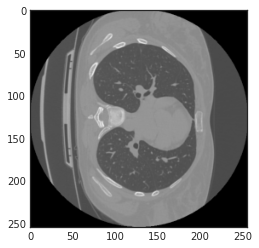

In [ ]:
plt.imshow (X[80,:,:,:,13])

In [ ]:
Y[80]

0